#### Notebook setup

In [ ]:
# %pip install -e .

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import warnings
import os, sys
from copy import deepcopy
from types import SimpleNamespace
from pprint import pprint as print

import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm.auto import tqdm, trange

from multirotor.helpers import control_allocation_matrix, DataLog
from multirotor.vehicle import MotorParams, VehicleParams, PropellerParams, SimulationParams, BatteryParams
from multirotor.controller import (
    PosController, VelController,
    AttController, RateController,
    AltController, AltRateController,
    Controller
)
from multirotor.simulation import Multirotor, Propeller, Motor, Battery
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.env import SpeedsMultirotorEnv, DynamicsMultirotorEnv
from multirotor.trajectories import Trajectory
from multirotor.visualize import plot_datalog

In [ ]:
import logging

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
# Plotting/display parameters
# https://stackoverflow.com/a/21009774/4591810
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Parameters

In [ ]:
# Tarot T18 params
bp = BatteryParams(max_voltage=25.2)
mp = MotorParams(
    moment_of_inertia=5e-5,
    # resistance=0.27,
    resistance=0.081,
    k_emf=0.0265,
    # k_motor=0.0932,
    speed_voltage_scaling= 0.0325,
    # speed_voltage_scaling= 0.025,
    max_current=38.
)
pp = PropellerParams(
    moment_of_inertia=1.85e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=mp #try motor = none
)
vp = VehicleParams(
    propellers=[pp] * 8,
    battery=bp,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    #originally was 0.375
    # angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.5*np.pi,
    angles=np.array([0.5, 1.5, 0.25, 1.75, 0.75, 1.25, 1, 0])*np.pi,
    distances=np.ones(8) * 0.635,
    # clockwise=[-1,1,-1,1,-1,1,-1,1],
    # clockwise=[1,-1,1,-1,1,-1,1,-1],
    clockwise=[1,1,-1,-1,-1,-1,1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2206, 0, 0],
        [0, 0.2206, 0.],
        [0, 0, 0.4238]
    ])
)
sp = SimulationParams(dt=0.0025, g=9.81)

### Multirotor

Simulating individual components of the multirotor. These make up the final `Multirotor` object.

#### Motor

In [ ]:
%matplotlib inline
# Plot motor speeds as a function of time and input voltage signal
plt.figure(figsize=(8,8))
motor = Motor(mp, sp)
for vsignal in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
    speeds = []
    motor.reset()
    speed = vsignal / mp.speed_voltage_scaling
    for i in range(200):
        speeds.append(motor.step(speed))
    plt.plot(speeds, label='%d rad/s' % speed)
plt.legend(ncol=2)
plt.ylabel('Speed rad/s')
plt.xlabel('Time /ms')

Learning a linear relationship for the equation $V = k_{scaling} * speed$ for motors. This is useful for `SpeedsMultirotorEnv` which takes speed signals as the input. This constant converts speeds to applied voltages. The default value in`MotorParams` is 1, meaning the actions are voltage signals.

In [ ]:
from multirotor.helpers import learn_speed_voltage_scaling

def make_motor_fn(params, sp):
    from copy import deepcopy
    params = deepcopy(params)
    params.speed_voltage_scaling = 1.
    def motor_step(signal):
        m = Motor(params, sp)
        for i in range(100):
            s = m.step(signal)
        return s
    return motor_step

print('Voltage = %.5f * speed' % (learn_speed_voltage_scaling(make_motor_fn(mp, sp))))

#### Propeller

The propeller can use a numerically solved thrust relationship, where thrust depends on airspeed. Or the easier option of using thrust coefficient is available.

In [ ]:
%matplotlib inline
# Plot propeller speed by numerically solving the thrust equation,
# *if* accurate propeller measurements are given in params
pp_ = deepcopy(pp)
pp_.use_thrust_constant = False # Set to true to just use k_thrust
prop = Propeller(pp_, sp)
plt.figure(figsize=(8,8))
speeds = np.linspace(0, 600, num=100)
for a in np.linspace(0, 10, 10, endpoint=False):
    thrusts = []
    for s in speeds:
        thrusts.append(prop.thrust(s, np.asarray([0, 0, a])))
    plt.plot(speeds, thrusts, label='%.1f m/s' % a)
plt.xlabel('Speed rad/s')
plt.ylabel('Thrust /N')
plt.title('Thrust with airspeed')
plt.legend(ncol=2)

#### Vehicle

Create a `Multirotor` object, given `VehicleParams` and `SimulationParams`

In [ ]:
# Combine propeller/motor/vehicle to get vehicle.
# Take off simulation
m = Multirotor(vp, sp)
log = DataLog(vehicle=m) # convenient logging class
m.reset()
m.state *= 0 # set to zero, reset() sets random values
action = m.allocate_control( # In this case action is allocated speed signals
    thrust=m.weight * 1.1,
    torques=np.asarray([0, 0, 0])
)
for i in range(500):
    m.step_speeds(action)
    log.log()
log.done_logging()
plt.plot(log.z)

### Gym Environment

In [ ]:
# this env takes the vector of [force_x, force_y, force_z, torque_x, torque_y, torque_z] to move
# the multirotor
env = DynamicsMultirotorEnv(Multirotor(vp, sp), max_rads=600)
env.reset()
log = DataLog(vehicle=env.vehicle)
for _ in range(100):
    env.step(np.asarray([0,0,env.vehicle.weight * 1.2, 0,0,0]))
    log.log()
log.done_logging()
plt.plot(log.z)

In [ ]:
# this env takes the vector of speed signals to move
# the multirotor
env = SpeedsMultirotorEnv(Multirotor(vp, sp))
env.reset()
log = DataLog(vehicle=env.vehicle)
for _ in range(100):
    env.step(np.ones(8) * 400)
    log.log()
log.done_logging()
plt.plot(log.z)

### PID Controller

This section explains how a PID controller is constructed. This is a cascaded PID architecture. See `Controller` docs
for more details.

In [ ]:
# From PID parameters file
def get_controller(m: Multirotor, max_velocity=5., max_acceleration=3.):
    assert m.simulation.dt <= 0.1, 'Simulation time step too large.'
    pos = PosController(
        1.0, 0., 0., 1., vehicle=m,
        max_velocity=max_velocity, max_acceleration=max_acceleration,
        square_root_scaling=False, leashing=False
    )
    vel = VelController(
        2.0, 1.0, 0.5,
        max_err_i=max_acceleration,
        max_tilt=np.pi/12,
        vehicle=m)
    att = AttController(
        [2.6875, 4.5, 4.5],
        0, 0.,
        max_err_i=1.,
        vehicle=m)
    rat = RateController(
        [4., 4., 4.],
        0, 0,
        max_err_i=0.5,
        max_acceleration=1.,
        vehicle=m)
    alt = AltController(
        1, 0, 0,
        max_err_i=1, vehicle=m,
        max_velocity=max_velocity)
    alt_rate = AltRateController(
        5, 0, 0,
        max_err_i=1, vehicle=m)
    ctrl = Controller(
        pos, vel, att, rat, alt, alt_rate,
        period_p=0.1, period_a=0.01, period_z=0.1
    )
    return ctrl

In [ ]:
%matplotlib inline
m = Multirotor(vp, sp)
ctrl = get_controller(m)
log = DataLog(vehicle=m, controller=ctrl)
for i in range(500):
    action = ctrl.step((0.01,0.1,1,0))
    # no allocation or motor simulation, for which we first need to
    # m.step_speeds(m.allocate_control(action[0], action[3:])
    # Instead, requested dynamics are fulfilled:
    dynamics = np.zeros(6, m.dtype)
    dynamics[2] = action[0]
    dynamics[3:] = action[1:]
    m.step_dynamics(dynamics)
    log.log()
log.done_logging()

plt.plot(log.actions[:,0], ls=':', label='thrust')
lines = plt.gca().lines
plt.twinx()
for s, axis in zip(log.actions.T[1:], ('x','y','z')):
    plt.plot(s, label=axis + '-torque')
plt.legend(handles=plt.gca().lines + lines)

#### Attitude Angle Controller

In [ ]:
m = Multirotor(vp, sp)
fz = m.weight
ctrl = get_controller(m)
att =  ctrl.ctrl_a
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(5000):
    ref = np.asarray([np.pi/18, 0, 0])
    # action is prescribed euler rate
    action = att.step(ref, m.orientation, dt=sp.dt)
    # action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=att.err_p[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi)
plt.twinx()
plt.plot(log.actions[:,0], ls=':', label='Rate rad/s')

#### Attitude Rate Controller

In [ ]:
m = Multirotor(vp, sp)
fz = m.weight
ctrl = get_controller(m)
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, controller=ctrl, other_vars=('err',))
for i in range(200):
    ref = np.asarray([np.pi/18, np.pi/12, 0])
    rate = att.step(ref, m.orientation, m.simulation.dt)
    torque = rat.step(rate, m.euler_rate, m.simulation.dt)
    action = np.clip(torque, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, 0, *action]))
    log.log(err=rat.err_p[0])
    log._actions[-1] = action
log.done_logging()

plt.plot(log.roll * 180 / np.pi, c='r', label='roll')
plt.plot(log.pitch * 180 / np.pi, c='g', label='pitch')
plt.plot(log.yaw * 180 / np.pi, c='b', label='yaw')
plt.ylabel('Orientation /deg')
plt.legend()
plt.twinx()
plt.plot(log.actions[:,0], ls=':', c='r')
plt.plot(log.actions[:,1], ls=':', c='g')
plt.plot(log.actions[:,2], ls=':', c='b')
plt.ylabel('Torque / Nm')
plt.title('Ref orientation' + str(ref))

#### Altitude Controller

In [ ]:
m = Multirotor(vp, sp)
ctrl = get_controller(m)
alt = ctrl.ctrl_z
alt_rate = ctrl.ctrl_vz
log = DataLog(vehicle=m, other_vars=('thrust',))
for i in range(5000):
    ref = np.asarray([1.])
    rate = alt.step(ref, m.position[2:], dt=0.1)
    action = alt_rate.step(rate, m.inertial_velocity[2:], dt=0.1)
    action = np.clip(action, a_min=-2*m.weight, a_max=2*m.weight)
    m.step_dynamics(np.asarray([0, 0, action[0], 0,0,0]))
    log.log(thrust=action)
    #log._actions[-1] = action
log.done_logging()

l = plt.plot(log.thrust.squeeze(), label='Thrust')
plt.twinx()
plt.plot(log.z, ls=':', label='Altitude /m')
plt.legend(handles=l+plt.gca().lines)

#### Position Controller

In [ ]:
m = Multirotor(vp, sp)
ctrl = get_controller(m)
pos = ctrl.ctrl_p
vel = ctrl.ctrl_v
rat = ctrl.ctrl_r
att = ctrl.ctrl_a
log = DataLog(vehicle=m, other_vars=('err', 'torques'))
for i in range(100):
    ref = np.asarray([1.,0.])
    
    # converting position -> velocity -> angles
    velocity = pos.step(ref, m.position[:2], dt=0.1)
    angles = vel.step(velocity, m.velocity[:2], dt=0.1)[::-1]
    # attitude controller operates at higher frequency
    rate = att.step(np.asarray([*angles, 0]), m.orientation, dt=0.01)
    action = rat.step(rate, m.euler_rate, dt=0.01)
    # clipping torques to prevent over-reactions
    action = np.clip(action, a_min=-0.1, a_max=0.1)
    m.step_dynamics(np.asarray([0, 0, m.weight, *action]))
    log.log(err=pos.err[0], torques=action)
log.done_logging()

plt.plot(log.x, label='x')
plt.plot(log.err, label='x-err')
plt.ylabel('x /m')
l = plt.gca().lines
plt.twinx()
plt.plot(log.torques[:,1], ls=':', label='y-torque', c='c')
plt.plot(log.pitch * 180 / np.pi, ls='-.', label='Pitch', c='m')
plt.legend(handles=plt.gca().lines+l)
# plt.plot(log.actions[:,0] * 180 / np.pi, ls=':')

### Parameter search

Using `optuna` to search over the space of PID controller parameters.

In [ ]:
from multirotor.optimize import optimize, DEFAULTS
print(DEFAULTS)

In [ ]:
# search over parameter space
study = optimize(vp, sp, ntrials=100)

In [ ]:
# # apply best parameters from study to controller, and run a simulation
# from multirotor.optimize import run_sim, apply_params

# env = DynamicsMultirotorEnv(Multirotor(vp, sp))
# traj = Trajectory(env.vehicle, [[0,0,0]], proximity=1)
# ctrl = get_controller(env.vehicle)
ctrl.set_params(**apply_params(None, params=study.best_params))

# env.reset()
# ctrl.reset()
# log = run_sim(env, traj, ctrl)
# plot_datalog(log)

### Simulation

Combining `Multiotor` and `Controller` to run a simulation. First, defining waypoints:

In [ ]:
# NASA flight test
# wp = np.asarray([
#     [0.0, 0.0, 30.0],
#     [164.0146725649829, -0.019177722744643688, 30.0],
#     [165.6418055187678, 111.5351051245816, 30.0],
#     [127.3337449710234, 165.73576059611514, 30.0],
#     [-187.28170707810204, 170.33217775914818, 45.0],
#     [-192.03130502498243, 106.30660058604553, 45.0],
#     [115.89920266153058, 100.8644210617058, 30.0],
#     [114.81859536317643, 26.80923518165946, 30.0],
#     [-21.459931490011513, 32.60508110653609, 30.0]
# ])
# wp = np.asarray([
#     [0,10,0],
#     [10,10,0],
#     [10,0,0],
#     [0,0,0]
# ])
wp = np.asarray([
    [0, 0, 0],
    [0, 0, 10]
])

Then, defining a disturbance (for example, wind). The disturabance function takes time, `Multirotor`, and returns the forces in the *body frame* of the vehicle.

In [ ]:
def wind(t, m):
    w_inertial = np.asarray([5 * np.sin(t * 2 * np.pi / 4000), 0, 0])
    dcm = direction_cosine_matrix(*m.orientation)
    return inertial_to_body(w_inertial, dcm)

In [ ]:
# Defining the run simulation function which illustrates all the
# steps that go into each step of the simulation.
# 
def run_sim(env, traj, ctrl, steps=60_000, disturbance=None):

    log = DataLog(env.vehicle, ctrl,
                  other_vars=('currents', 'voltages'))

    disturb_force, disturb_torque = 0., 0
    for i, (pos, feed_forward_vel) in tqdm(
        enumerate(traj), leave=False, total=steps
    ):
        if i==steps: break
        # Generate reference for controller
        ref = np.asarray([*pos, 0.])
        # Get prescribed dynamics for system as thrust and torques
        dynamics = ctrl.step(ref, feed_forward_velocity=feed_forward_vel)
        thrust, torques = dynamics[0], dynamics[1:]
        # Allocate control: Convert dynamics into motor rad/s
        action = env.vehicle.allocate_control(thrust, torques)
        # get any disturbances
        if disturbance is not None:
            disturb_force, disturb_torque = disturbance(i, env.vehicle)
        # Send speeds to environment
        state, *_ = env.step(
            action, disturb_forces=disturb_force, disturb_torques=disturb_torque
        )
        alloc_errs = np.asarray([thrust, *torques]) - env.vehicle.alloc @ action**2

        log.log(currents=[p.motor.current for p in env.vehicle.propellers],
                voltages=[p.motor.voltage for p in env.vehicle.propellers])

        if np.any(np.abs(env.vehicle.orientation[:2]) > np.pi/6): break

    log.done_logging()
    return log

In [ ]:
env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
traj = Trajectory(env.vehicle, wp, proximity=2, resolution=10)
ctrl = get_controller(env.vehicle, max_velocity=3.)
env.reset()
ctrl.reset()
log = run_sim(env, traj, ctrl, steps=60_000, disturbance=None)

In [ ]:
# Currents
plt.plot(log.currents, ls=':')
plt.ylabel('Motor current /A')
plt.title('Individual motor currents')
plt.xlabel('Time /ms')

In [ ]:
# Voltages
plt.plot(log.voltages, ls=':')
plt.ylim(0, 30)
plt.ylabel('Motor voltage /A')
plt.xlabel('Time /ms')
plt.title('Voltages')

In [ ]:
# PLot positions, velocities, prescribed dynamics
plot_datalog(log)

In [ ]:
plot_datalog(log, plots=('pos', 'vel'))

In [ ]:
# 3D plot of trajectory
# %matplotlib notebook
fig = plt.figure()
xlim = ylim = zlim = (np.min(log.position), np.max(log.position))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot(log.x, log.y, log.z)

### Logging and Plotting

In [ ]:
def clear_file(file_path):
    file_path="logs/"+file_path
    with open(file_path, 'w') as file:
        pass

In [ ]:
def logToFile(string_to_log, file_path):
    file_path="logs/"+file_path
    with open(file_path, 'a') as file:
        file.write(string_to_log + '\n')

In [ ]:
def printLogMotor(log):
    element_data = {}

    first_key = next(iter(log))
    for index in range(len(log[first_key])):
        element_data[index] = [data[index] for data in log.values()]

    plt.figure(figsize=(12, 4))

    # Plot the data for each element
    for index, data in element_data.items():
        plt.plot(list(log.keys()), data, label=f"Motor {index+1}")

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Motor command")
    plt.title("Motor Commands over time")

    # Add legend
    plt.legend(loc='upper left', fontsize='small')

    # Display the plot
    plt.show()

In [ ]:
def printLogAccel(log):
    element_data = {}

    first_key = next(iter(log))
    for index in range(len(log[first_key])):
        element_data[index] = [data[index] for data in log.values()]

    plt.figure(figsize=(12, 4))

    # Plot the data for each element
    for index, data in element_data.items():
        plt.plot(list(action_log.keys()), data, label=str(chr(ord('x') + index)))

    # Set plot labels and title
    plt.xlabel("Frames")
    plt.ylabel("Acceleration")
    plt.title("Acceleration over Frames")

    # Add legend
    plt.legend(loc='upper left', fontsize='small')

    # Display the plot
    plt.show()

### AP Simulation

In [ ]:
import socket
import time
import json
import struct
from multirotor.coords import direction_cosine_matrix, body_to_inertial 

In [ ]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    velo = state[3:6]
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()

    logToFile(str(pos[2]), "zLog.txt")

    accel[2] = -9.8

    pos[2] = -1*pos[2]
    pos[0], pos[1] = pos[1], pos[0]

    dcm = direction_cosine_matrix(*euler)
    v_inertial = body_to_inertial(velo, dcm).tolist()
    v_inertial[2] = -1*v_inertial[2]
    v_inertial[0], v_inertial[1] = v_inertial[1], v_inertial[0]

    gyro[0], gyro[1] = gyro[1], gyro[0]
    gyro[2] = -1*gyro[2]
    euler[0], euler[1] = euler[1], euler[0]
    euler[2] = -1*euler[2]

    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : v_inertial
    }

    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"

    logToFile(json.dumps(JSON_fmt,separators=(',', ':')), "JSONLog.txt")

    return JSON_string


In [ ]:
def ap_sim(env, sock, steps=600000, disturbance=None):
    ap_log = DataLog(env.vehicle, other_vars=("propeller_speed",))
    command_logger = {}
    accel_logger = {}
    
    disturb_force, disturb_torque = 0., 0

    curr_time = 0  # Get the current time in seconds
    RATE_HZ = 400
    TIME_STEP = 1/RATE_HZ
    last_frame = -1
    frame_count = 0
    frame_time = time.time()
    print_frame_count = 500

    try:
        for i in range(0, steps):
            try:   
                data, addr = sock.recvfrom(100)
                parse_format = 'HHI16H'
                magic = 18458
                if len(data) != struct.calcsize(parse_format):
                    print("got packet of len %u, expected %u" % (len(data), struct.calcsize(parse_format)))
                    continue
                unpacked_data = struct.unpack(parse_format, data)
                if magic != unpacked_data[0]:
                    print("Incorrect protocol magic %u should be %u" % (unpacked_data[0], magic))
                    continue

                frame_rate = unpacked_data[1]
                frame_count = unpacked_data[2]
                pwm = np.array(unpacked_data[3:11])

                string_action = " ".join(str(element) for element in pwm.tolist())
                logToFile(string_action, "pwmLog.txt")

                if frame_count < last_frame:
                    print('Reset controller')
                elif frame_count == last_frame:
                    print('Duplicate frame')
                    continue
                if frame_count != last_frame + 1 and last_frame != 0:
                    print("Missed %u frames" % (frame_count - last_frame))
                    continue
                last_frame = frame_count
                
                curr_time += TIME_STEP

                if disturbance is not None:
                    disturb_force, disturb_torque = disturbance(i, env.vehicle)

                action = (pwm-1000)*0.575
                
                string_action = " ".join(str(element) for element in action.tolist())
                logToFile(string_action, "actionLog.txt")

                state, *_ = env.step(
                    action, disturb_forces=disturb_force, disturb_torques=disturb_torque
                )

                accel = env.vehicle.dxdt_speeds(0, state, action, disturb_forces=disturb_force, disturb_torques=disturb_torque)[3:6]
                JSON_string = changeToJSONString(curr_time, state, accel)

                sock.sendto(bytes(JSON_string,"ascii"), addr)
                
                if action[0] != 0:
                    ap_log.log(propeller_speed=[p.state for p in env.vehicle.propellers])
                    command_logger[i] = action.tolist()
                    accel_logger[i] = accel.tolist()

                # Track frame rate
                if frame_count % print_frame_count == 0:
                    now = time.time()
                    total_time = now - frame_time
                    logToFile("%.2f fps T=%.3f dt=%.3f frame=%.1f rate=%d" % (print_frame_count/total_time, curr_time, total_time, frame_count, RATE_HZ), "frameLog.txt")
                    frame_time = now
            except json.JSONDecodeError:
                print("Invalid JSON data received")
            except socket.timeout:
                continue
            except KeyboardInterrupt:
                sock.close()
            except Exception as e:
                if not isinstance(e, OSError):
                    raise e
                sock.close()
                break
    finally:
        sock.close()
    
    ap_log.done_logging()   
    
    return ap_log, command_logger, accel_logger


In [24]:

UDP_IP = "127.0.0.1"  # Listen on all available interfaces
UDP_PORT = 9002

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))
sock.settimeout(0.1)  # Set a timeout value of 1 second on the socket object

clear_file("frameLog.txt")
clear_file("JSONLog.txt")
clear_file("pwmLog.txt")
clear_file("actionLog.txt")
clear_file("zLog.txt")
env = SpeedsMultirotorEnv(vehicle=Multirotor(vp, sp)) # step() takes speed signals
env.reset(np.zeros(12))
ap_log, action_log, accel_log = ap_sim(env, sock, steps=600000, disturbance=None)

sock.close()

{'pos': <Axes: title={'center': 'Position and Orientation'}, ylabel='Orientation /deg'>,
 'vel': <Axes: title={'center': 'Velocities'}>}

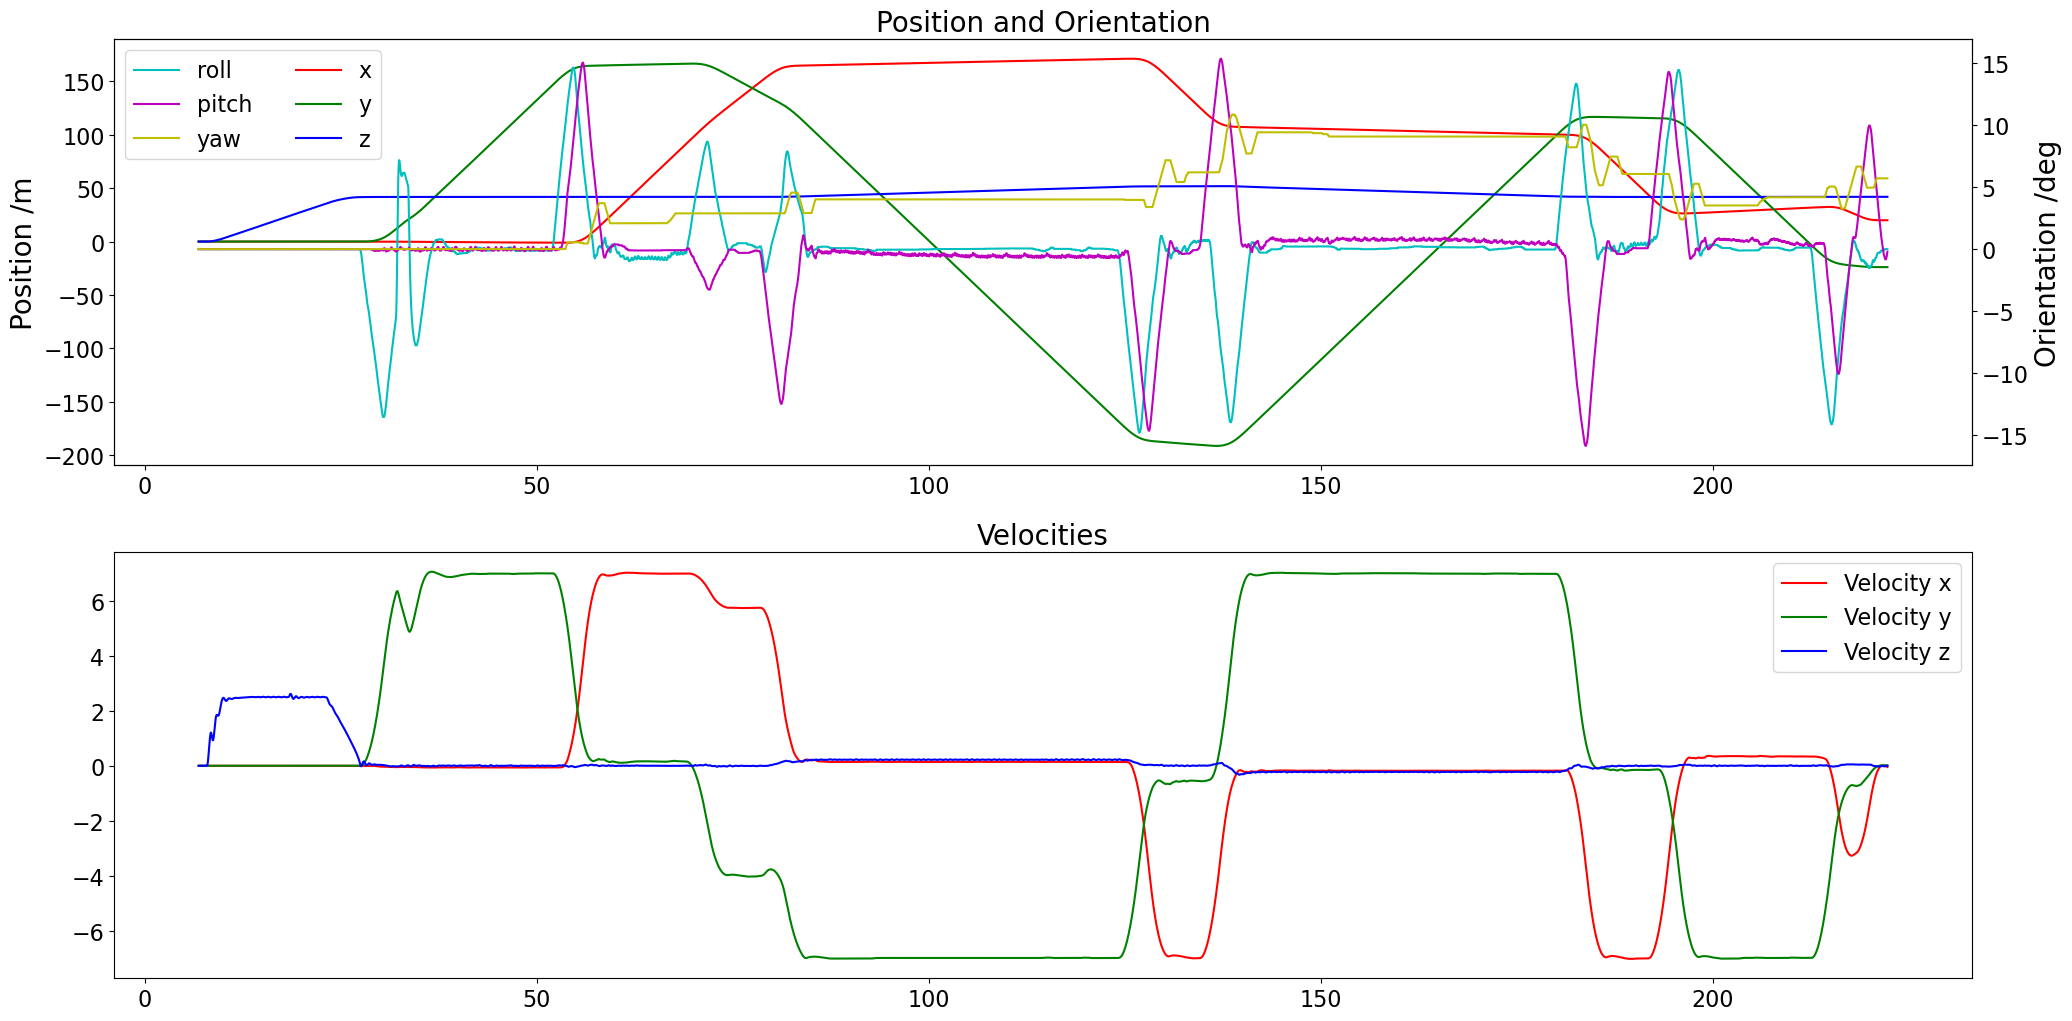

In [25]:
plot_datalog(ap_log, plots=('pos', 'vel'))

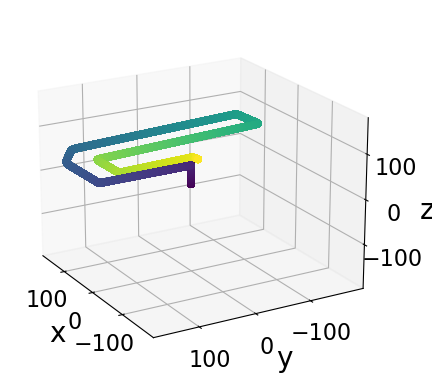

In [26]:
fig = plt.figure()
xlim = ylim = zlim = (np.min(ap_log.position), np.max(ap_log.position))
ax = fig.add_subplot(projection='3d', xlim=xlim, ylim=ylim, zlim=zlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20,150)
ax.scatter(ap_log.x, ap_log.y, ap_log.z, c=ap_log.t)

In [ ]:
printLogMotor(action_log)

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ap_log.propeller_speed)
plt.ylabel('Propeller Speeds rad/s')
plt.title('Individual propeller speeds')
plt.xlabel('Frames')

In [ ]:
printLogAccel(accel_log)

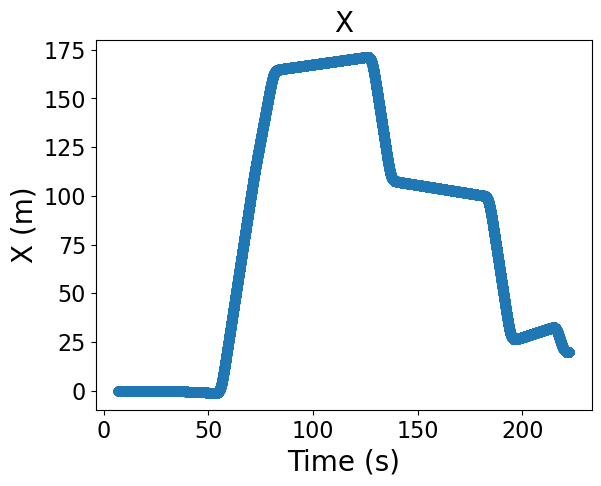

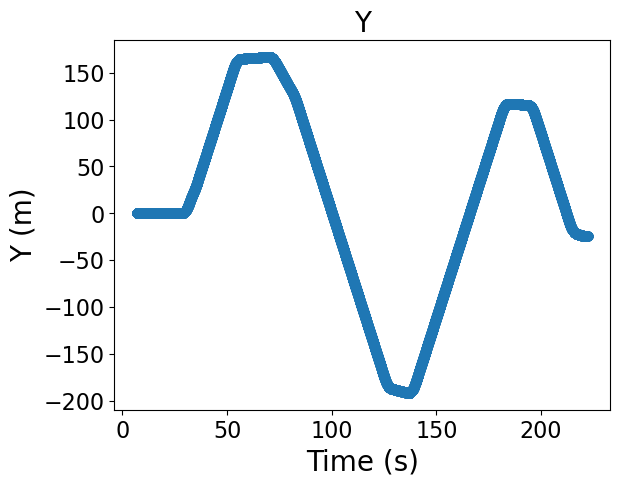

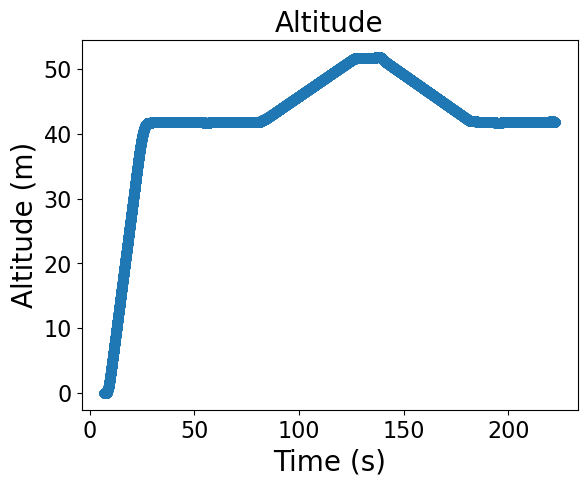

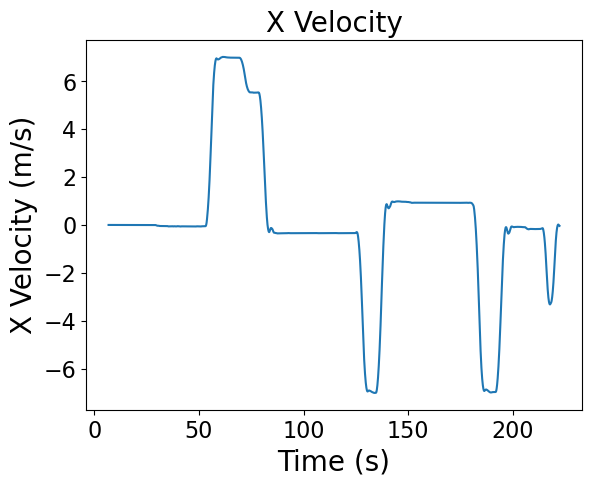

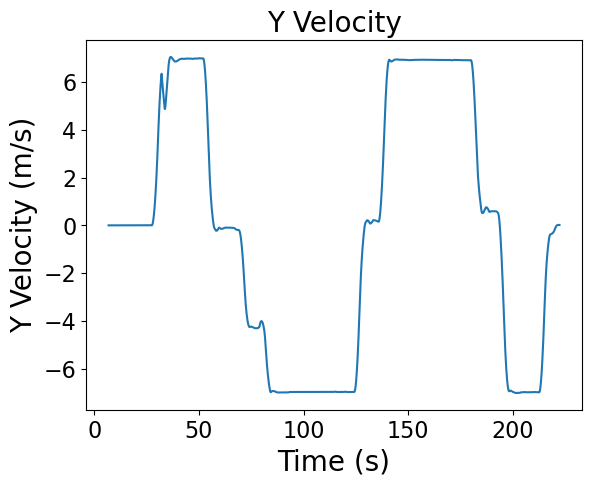

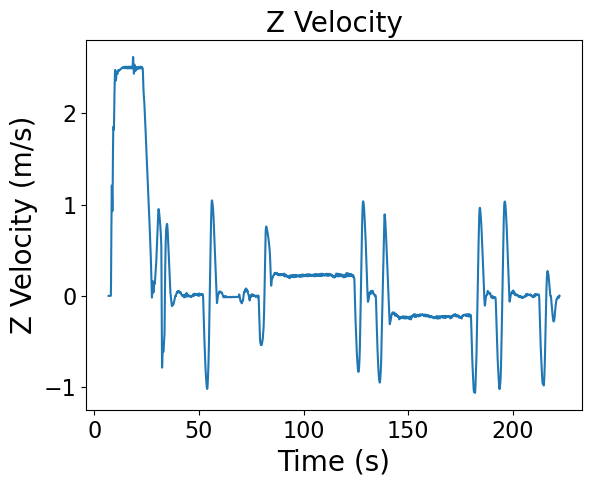

In [27]:
folder = "graphs/"

log = ap_log

plt.title("X")
plt.xlabel("Time (s)")
plt.ylabel("X (m)")
plt.scatter(log.t,log.x)
plt.savefig(folder + 'X')
plt.show()

plt.title("Y")
plt.xlabel("Time (s)")
plt.ylabel("Y (m)")
plt.scatter(log.t,log.y)
plt.savefig(folder + 'Y')
plt.show()

plt.title("Altitude")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.scatter(log.t,log.z)
plt.savefig(folder + 'alt')
plt.show()

plt.title("X Velocity")
plt.xlabel("Time (s)")
plt.ylabel("X Velocity (m/s)")
plt.plot(log.t,log.velocity[:,0])
plt.savefig(folder + 'xvel')
plt.show()

plt.title("Y Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Y Velocity (m/s)")
plt.plot(log.t,log.velocity[:,1])
plt.savefig(folder + 'yvel')
plt.show()

plt.title("Z Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Z Velocity (m/s)")
plt.plot(log.t,log.velocity[:,2])
plt.savefig(folder + 'zvel')
plt.show()